# Séries temporais

***

In [174]:
# importando as bibliotecas

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score

import tensorflow as tf
import random

## Análise do conjunto de dados

Uma sequência de observações de uma variável que ocorre em ordem durante um intervalo de tempo.

Vamos usar o [Air Passengers dataset](https://www.kaggle.com/datasets/rakannimer/air-passengers).

In [175]:
df = pd.read_csv("https://raw.githubusercontent.com/gabrielh10/ml_practice_tutoring_2/master/datasets/AirPassengers.csv")

In [176]:
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [177]:
print("Dimensões do conjunto de dados:", df.shape)

Dimensões do conjunto de dados: (144, 2)


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [179]:
# A coluna month está como objeto vamos transformar ela em datatime
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True)

X = df.iloc[:,0]
y = df.iloc[:,1] #variavel alvo

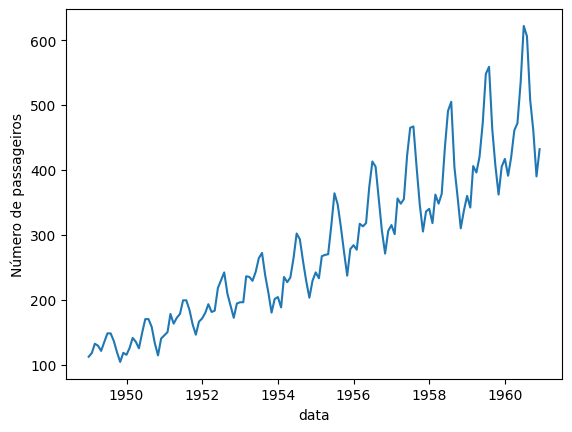

In [180]:
plt.xlabel('data')
plt.ylabel('Número de passageiros')
plt.plot(X, y)

## Como avaliar os dados?

Vamos usar janelas do mesmo tamanho.

A classe `TimeSeriesSplit` é usada para dividir os dados de séries temporais de uma maneira que respeite a ordem temporal dos dados. Em vez de dividir aleatoriamente como em validação cruzada comum, ela faz isso de uma maneira que os dados anteriores sempre são usados para treinar e os dados mais recentes para testar.

In [181]:
# vamos visualizar um exemplo
X_aux = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_aux = np.array([1, 2, 3, 4, 5, 6])

#Valores default: n_splits=5, max_train_size=None, test_size=None, gap=0
# Gap - determina o número de amostras a serem excluídas do final de cada conjunto de treinamento antes do conjunto de teste.
tscv = TimeSeriesSplit(gap=0, n_splits=5)
# tscv = TimeSeriesSplit(gap=1, n_splits=3)

print(tscv)

for i, (train_index, test_index) in enumerate(tscv.split(X_aux)):
    print("\nFOLD", i)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_aux[train_index], X_aux[test_index]
    y_train, y_test = y_aux[train_index], y_aux[test_index]
    #print("X_train:", X_train)
    #print("X_test:", X_test)
    #print("y_train:", y_train)
    #print("y_test:", y_test)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

FOLD 0
TRAIN: [0] TEST: [1]

FOLD 1
TRAIN: [0 1] TEST: [2]

FOLD 2
TRAIN: [0 1 2] TEST: [3]

FOLD 3
TRAIN: [0 1 2 3] TEST: [4]

FOLD 4
TRAIN: [0 1 2 3 4] TEST: [5]


### Treinando o modelo SVR (*Support Vector Regression*) - [documentação](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

A regressão de vetor de suporte (SVR) é um tipo de máquina de vetor de suporte (SVM) usada para tarefas de regressão. Ele tenta encontrar uma função que preveja melhor o valor de saída contínua para um determinado valor de entrada.

Métricas de avaliação:

[RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) = $\sqrt{\frac{1}{n}\sum_{t=1}^{n}(y_t-\hat{y_t})^2}$

[MAPE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) = $\frac{1}{n}\sum_{t=1}^{n}|100 \frac{y_t - \hat{y_t}}{y_t}|$


In [182]:
def evaluate_model_with_kfold(kf, model):
    results = []
    fold = 0
    for train, test in kf.split(X, y):


        X_train, X_test = pd.DataFrame(X.iloc[train]), pd.DataFrame(X.iloc[test])
        y_train, y_test = y.iloc[train], y.iloc[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Se for usar rmse
        rmse = root_mean_squared_error(y_test, y_pred)
        #se for usar MAPE
        mape = mean_absolute_percentage_error(y_test, y_pred)

        print("Fold %d: %.3f" %(fold, rmse))

        results.append(rmse)
        fold += 1

    print("RMSE média (desvio): %.3f +- (%.3f)" %(np.array(results).mean(), np.array(results).std()))

In [183]:
# # n_splits deve ser pelo menos 2
tscv = TimeSeriesSplit(n_splits=3)
evaluate_model_with_kfold(tscv, SVR())

Fold 0: 85.210
Fold 1: 154.921
Fold 2: 219.762
RMSE média (desvio): 153.298 +- (54.943)


In [184]:
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=3)
evaluate_model_with_kfold(tscv, RandomForestRegressor())

Fold 0: 66.612
Fold 1: 117.274
Fold 2: 122.019
RMSE média (desvio): 101.968 +- (25.075)


### Uma outra abordagem... E se fixarmos uma janela e utilizarmos LSTM?

In [185]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [186]:
# Normalizando o numero de passageiros
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df['Passengers'].values.reshape(-1, 1))
dataset

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [187]:
def create_dataset_with_windows(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [188]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Definindo o tamanho da janela. Usamos um look_back de 12 para capturar a sazonalidade anual.
look_back = 12
trainX, trainY = create_dataset(dataset, look_back)
print(trainX.shape, trainY.shape)
pd.DataFrame(trainX)

(131, 12) (131,)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0.015444,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027
1,0.027027,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236
2,0.054054,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471
3,0.048263,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429
4,0.032819,0.059846,0.084942,0.084942,0.061776,0.028958,0.000000,0.027027,0.021236,0.042471,0.071429,0.059846
...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.857143,0.878378,0.693050,0.584942,0.498069,0.581081,0.604247,0.554054,0.608108,0.689189,0.710425,0.832046
127,0.878378,0.693050,0.584942,0.498069,0.581081,0.604247,0.554054,0.608108,0.689189,0.710425,0.832046,1.000000
128,0.693050,0.584942,0.498069,0.581081,0.604247,0.554054,0.608108,0.689189,0.710425,0.832046,1.000000,0.969112
129,0.584942,0.498069,0.581081,0.604247,0.554054,0.608108,0.689189,0.710425,0.832046,1.000000,0.969112,0.779923


In [189]:
# Redimensionar a entrada para o formato [amostras, passos de tempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

#Fitting do LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1))) # 50 unidades na camada LSTM
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)

Epoch 1/25
131/131 - 2s - 14ms/step - loss: 0.0260
Epoch 2/25
131/131 - 1s - 5ms/step - loss: 0.0112
Epoch 3/25
131/131 - 0s - 4ms/step - loss: 0.0106
Epoch 4/25
131/131 - 1s - 5ms/step - loss: 0.0099
Epoch 5/25
131/131 - 1s - 5ms/step - loss: 0.0093
Epoch 6/25
131/131 - 0s - 4ms/step - loss: 0.0085
Epoch 7/25
131/131 - 0s - 4ms/step - loss: 0.0076
Epoch 8/25
131/131 - 1s - 5ms/step - loss: 0.0064
Epoch 9/25
131/131 - 0s - 4ms/step - loss: 0.0049
Epoch 10/25
131/131 - 0s - 4ms/step - loss: 0.0042
Epoch 11/25
131/131 - 1s - 5ms/step - loss: 0.0036
Epoch 12/25
131/131 - 0s - 4ms/step - loss: 0.0034
Epoch 13/25
131/131 - 0s - 4ms/step - loss: 0.0032
Epoch 14/25
131/131 - 0s - 3ms/step - loss: 0.0031
Epoch 15/25
131/131 - 1s - 6ms/step - loss: 0.0030
Epoch 16/25
131/131 - 1s - 5ms/step - loss: 0.0029
Epoch 17/25
131/131 - 1s - 9ms/step - loss: 0.0029
Epoch 18/25
131/131 - 0s - 4ms/step - loss: 0.0028
Epoch 19/25
131/131 - 1s - 5ms/step - loss: 0.0028
Epoch 20/25
131/131 - 1s - 5ms/step - l

In [190]:
#Gerar previsões futuras com a janela deslizante
future_predictions_scaled = []
last_sequence = dataset[-look_back:]

for _ in range(12): # Prever os próximos 12 meses
    prediction = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions_scaled.append(prediction[0, 0])

    # "Deslizar" a janela: remover o primeiro valor e adicionar a nova previsão no final
    last_sequence = np.append(last_sequence[1:], prediction, axis=0)

future_predictions_scaled

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[np.float32(0.53647906),
 np.float32(0.5304359),
 np.float32(0.5690754),
 np.float32(0.6322215),
 np.float32(0.72004336),
 np.float32(0.855196),
 np.float32(1.0002184),
 np.float32(1.0448368),
 np.float32(0.9588943),
 np.float32(0.8182069),
 np.float32(0.65758586),
 np.float32(0.5569087)]

In [191]:
#Reverte a normalização das previsões
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
future_predictions

array([[381.89618],
       [378.7658 ],
       [398.78107],
       [431.49075],
       [476.98248],
       [546.9915 ],
       [622.1131 ],
       [645.2254 ],
       [600.7073 ],
       [527.8312 ],
       [444.6295 ],
       [392.47873]], dtype=float32)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


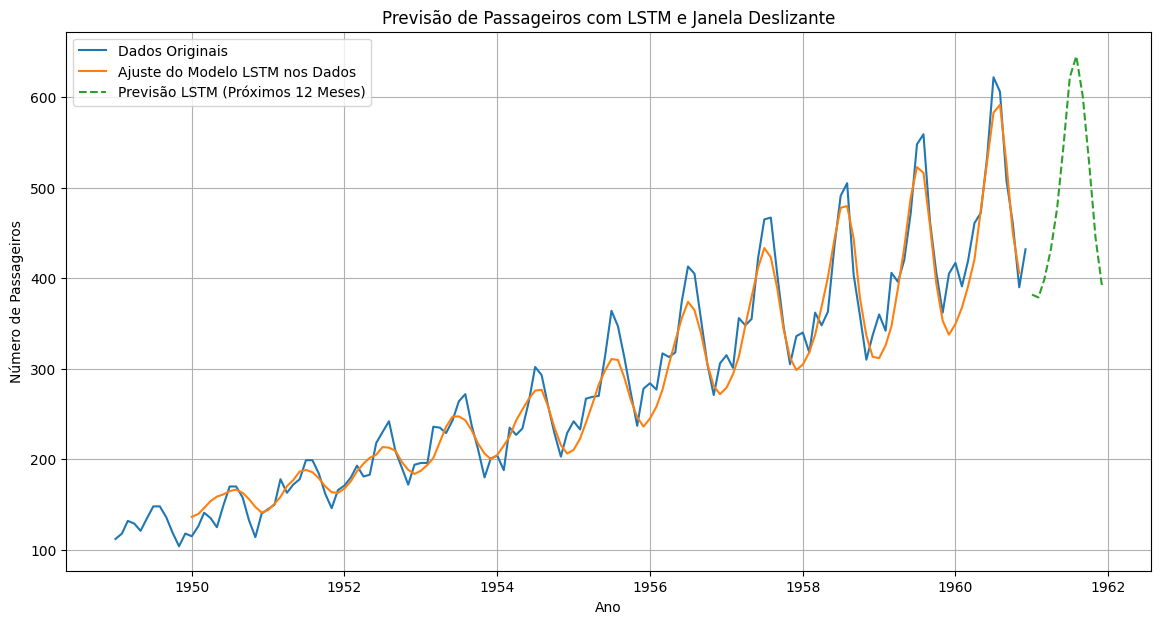

In [192]:
# Criar as datas futuras para o eixo X do gráfico
last_date = df['Month'].iloc[-1] # Get the actual datetime value
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')

# Gerar previsões no conjunto de treino para plotar o ajuste do modelo
train_predict = model.predict(trainX)
train_predict = scaler.inverse_transform(train_predict)
train_predict_plot = np.empty_like(df['Passengers'].values, dtype=float).reshape(-1, 1)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Plotar os dados
plt.figure(figsize=(14, 7))
plt.plot(df['Month'], df['Passengers'], label='Dados Originais') # Use 'Month' column for x-axis
plt.plot(df['Month'][look_back:len(train_predict) + look_back], train_predict_plot[look_back:len(train_predict) + look_back], label='Ajuste do Modelo LSTM nos Dados') # Use 'Month' column for x-axis
plt.plot(future_dates, future_predictions, label='Previsão LSTM (Próximos 12 Meses)', linestyle='--')
plt.title('Previsão de Passageiros com LSTM e Janela Deslizante')
plt.xlabel('Ano')
plt.ylabel('Número de Passageiros')
plt.legend()
plt.grid(True)
plt.show()

In [193]:
#Tabela de predições dos próximos 12 meses
predictions_df = pd.DataFrame({'Month': future_dates, 'Predicted_Passengers': future_predictions.flatten()})
print("Previsões para os próximos 12 meses:")
print(predictions_df)

Previsões para os próximos 12 meses:
        Month  Predicted_Passengers
0  1961-01-01            381.896179
1  1961-02-01            378.765808
2  1961-03-01            398.781067
3  1961-04-01            431.490753
4  1961-05-01            476.982483
5  1961-06-01            546.991516
6  1961-07-01            622.113098
7  1961-08-01            645.225403
8  1961-09-01            600.707275
9  1961-10-01            527.831177
10 1961-11-01            444.629486
11 1961-12-01            392.478729
